# Simulación de despacho de buses y predicción de demanda
Este cuaderno muestra un proceso completo para la predicción de la demanda de pasajeros en diferentes rutas.
Incluye:
- Carga y preprocesamiento de datos
- Entrenamiento del modelo Prophet
- Generación de pronósticos


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas.api.types import CategoricalDtype
from prophet.make_holidays import make_holidays_df
import joblib
import os
from datetime import datetime, timedelta
import random
import math

## 1. Cargar y preparar los datos

En esta sección, cargamos los datos de un archivo CSV y los preparamos para su posterior uso en la predicción de demanda. Esto incluye el preprocesamiento de las columnas necesarias, el manejo de datos faltantes y la creación de nuevas características relevantes para el análisis.


In [ ]:
# Importar archivos de GOOGLE DRIVE
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def cargar_y_preparar_datos(ruta_archivo):
    """
    Carga y preprocesa los datos del archivo CSV.

    Parameters:
    - ruta_archivo (str): Ruta al archivo CSV.

    Returns:
    - data (pd.DataFrame): DataFrame con los datos preprocesados.
    """
    # Cargar los datos
    data = pd.read_csv(ruta_archivo, sep=';')

    # Seleccionar las columnas relevantes
    data = data[['linea', 'fecha', 'vendeHora', 'sentido']]

    # Eliminar filas con valores nulos
    data = data.dropna()

    #Pasar las columnas de data a int 64
    data = data.astype('int64')

    # Convertir tipos de datos
    data['linea'] = data['linea'].astype(int)
    data['sentido'] = data['sentido'].astype(int)
    data['fecha'] = pd.to_datetime(data['fecha'], format='%Y%m%d')
    data['vendeHora'] = data['vendeHora'].astype(str).str.zfill(4)
    data['hora'] = data['vendeHora'].str[:2] + ':' + data['vendeHora'].str[2:]
    data['hora'] = pd.to_datetime(data['hora'], format='%H:%M').dt.time
    data['datetime'] = data.apply(lambda row: pd.Timestamp.combine(row['fecha'], row['hora']), axis=1)

    # Crear columnas adicionales
    data['dia_semana'] = data['fecha'].dt.day_name()
    data['mes'] = data['fecha'].dt.month_name()
    data['hora_int'] = data['hora'].apply(lambda x: x.hour)
    data['es_fin_de_semana'] = data['dia_semana'].isin(['Saturday', 'Sunday']).astype(int)
    data['es_hora_pico'] = data['hora_int'].isin([7, 8, 9, 17, 18, 19]).astype(int)

    # Mapear nombres de rutas
    linea_a_ruta = {
        1: 'Especial', 2: 'Pradera UPB FS', 3: 'PANZENU', 5: 'DORADO', 6: 'KM30',
        7: 'SANTANDER', 8: 'TAMBO CIRCUNVALAR', 9: 'MOGAMBO 22', 12: '6 DE MARZO',
        13: 'CARRIZAL', 17: 'PRADERA 27', 18: 'Furatena', 20: 'KM 15', 21: 'SANTA LUCIA',
        24: 'TERMINAL - AEROPUERTO', 26: 'RANCHO GRANDE', 27: 'SABANAL', 34: 'LETICIA',
        36: 'AGUAS VIVAS', 37: 'CAÑO VIEJO', 97: 'Auditorias RE'
    }
    data['ruta'] = data['linea'].map(linea_a_ruta)

    return data


## 2. Entrenar el modelo Prophet

A continuación, se entrenará un modelo de predicción utilizando **Prophet**. El modelo se entrenará con los datos filtrados por ruta y sentido, y luego se evaluará el rendimiento del modelo en términos de **RMSE** y **MAE**.


In [ ]:
def entrenar_modelo_prophet(data, ruta, sentido, frecuencia='10T', split_date='2024-06-01'):
    """
    Entrena un modelo Prophet para una ruta y sentido específicos, realizando validación cruzada
    y ajustando hiperparámetros para mejorar el rendimiento.

    Parameters:
    - data (pd.DataFrame): DataFrame con los datos preparados.
    - ruta (str): Nombre de la ruta.
    - sentido (int): Sentido de la ruta (1 o 2).
    - frecuencia (str): Frecuencia de resampling (e.g., '10T' para 10 minutos).
    - split_date (str): Fecha de corte para dividir los datos en entrenamiento y prueba.

    Returns:
    - model (Prophet): Modelo Prophet entrenado con los mejores hiperparámetros.
    - train_prophet (pd.DataFrame): Datos de entrenamiento preparados para Prophet.
    - test_prophet (pd.DataFrame): Datos de prueba preparados para Prophet.
    - metrics (dict): Métricas de evaluación del modelo.
    """
    # Filtrar los datos por ruta y sentido
    data_filtrada = data[(data['ruta'] == ruta) & (data['sentido'] == sentido)]

    if data_filtrada.empty:
        print(f"No hay datos para la ruta {ruta} en sentido {sentido}.")
        return None, None, None, None

    # Establecer el índice de datetime
    data_filtrada = data_filtrada.set_index('datetime')

    # Resample para obtener la demanda agregada en el intervalo de tiempo deseado
    data_resampled = data_filtrada.resample(frecuencia).size().reset_index(name='demanda')

    # Crear columnas adicionales necesarias
    data_resampled['dia_semana'] = data_resampled['datetime'].dt.day_name()
    data_resampled['hora'] = data_resampled['datetime'].dt.hour
    data_resampled['mes'] = data_resampled['datetime'].dt.month_name()
    data_resampled['es_fin_de_semana'] = data_resampled['dia_semana'].isin(['Saturday', 'Sunday']).astype(int)
    data_resampled['es_hora_pico'] = data_resampled['hora'].isin([7, 8, 9, 17, 18, 19]).astype(int)

    # Crear el dataframe de días festivos
    years = data_resampled['datetime'].dt.year.unique()
    colombia_holidays = make_holidays_df(year_list=years, country='CO')

    # Preparar los datos para Prophet
    data_prophet = data_resampled.rename(columns={'datetime': 'ds', 'demanda': 'y'})
    data_prophet['es_hora_pico'] = data_resampled['es_hora_pico']
    data_prophet['es_fin_de_semana'] = data_resampled['es_fin_de_semana']
    data_prophet['es_dia_festivo'] = data_prophet['ds'].isin(colombia_holidays['ds']).astype(int)

    # Dividir los datos en entrenamiento y prueba
    train = data_prophet[data_prophet['ds'] <= split_date].copy()
    test = data_prophet[data_prophet['ds'] > split_date].copy()

    # Reset the index
    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)

    # Validar que el conjunto de entrenamiento y prueba no estén vacíos
    if train.empty:
        print(f"Conjunto de entrenamiento vacío para ruta {ruta} en sentido {sentido}.")
        return None, None, None, None
    if test.empty:
        print(f"Conjunto de prueba vacío para ruta {ruta} en sentido {sentido}.")
        return None, None, None, None

    # Lista de hiperparámetros a probar
    param_grid = {
        'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
        'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
    }

    # Mejor RMSE inicializado en un valor alto
    best_rmse = float('inf')
    best_params = {}

    # Grid Search para encontrar los mejores hiperparámetros
    for cps in param_grid['changepoint_prior_scale']:
        for sps in param_grid['seasonality_prior_scale']:
            # Inicializar el modelo Prophet con los hiperparámetros actuales
            model = Prophet(
                holidays=colombia_holidays,
                changepoint_prior_scale=cps,
                seasonality_prior_scale=sps
            )
            # Añadir regresores adicionales
            model.add_regressor('es_hora_pico')
            model.add_regressor('es_fin_de_semana')
            model.add_regressor('es_dia_festivo')

            # Entrenar el modelo
            model.fit(train)

            # Validación cruzada
            df_cv = cross_validation(
                model,
                initial='180 days',
                period='30 days',
                horizon='30 days',
                parallel="processes"
            )

            # Calcular métricas de rendimiento
            df_p = performance_metrics(df_cv, rolling_window=1)

            # Obtener el RMSE promedio
            rmse = df_p['rmse'].mean()

            # Si el RMSE es mejor que el anterior, actualizar los mejores hiperparámetros
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = {
                    'changepoint_prior_scale': cps,
                    'seasonality_prior_scale': sps
                }

    print(f"Mejores hiperparámetros para ruta {ruta} sentido {sentido}: {best_params}")
    print(f"RMSE de validación cruzada: {best_rmse}")

    # Entrenar el modelo final con los mejores hiperparámetros
    model = Prophet(
        holidays=colombia_holidays,
        changepoint_prior_scale=best_params['changepoint_prior_scale'],
        seasonality_prior_scale=best_params['seasonality_prior_scale']
    )
    model.add_regressor('es_hora_pico')
    model.add_regressor('es_fin_de_semana')
    model.add_regressor('es_dia_festivo')
    model.fit(train)

    # Predecir en el conjunto de prueba
    forecast = model.predict(test)

    # Evaluar el modelo en el conjunto de prueba
    rmse_test = np.sqrt(mean_squared_error(test['y'], forecast['yhat']))
    mae_test = mean_absolute_error(test['y'], forecast['yhat'])
    metrics = {'RMSE': rmse_test, 'MAE': mae_test}

    print(f"Evaluación en conjunto de prueba para ruta {ruta} sentido {sentido}:")
    print(f"RMSE: {rmse_test}")
    print(f"MAE: {mae_test}")

    return model, train, test, metrics


## 3. Generar pronósticos futuros

Una vez que el modelo ha sido entrenado, generaremos los pronósticos de demanda futuros para los diferentes intervalos de tiempo. Estos pronósticos servirán como base para la simulación de la operación de la flota de buses.


In [ ]:
def generar_pronostico_futuro(model, fecha_prediccion, frecuencia='10T', periodos=None):
    """
    Genera pronósticos futuros utilizando un modelo Prophet entrenado.

    Parameters:
    - model (Prophet): Modelo Prophet entrenado.
    - fecha_prediccion (str): Fecha de inicio para el pronóstico (e.g., '2024-08-05').
    - frecuencia (str): Frecuencia de los pronósticos (e.g., '10T' para 10 minutos).
    - periodos (int): Número de periodos a predecir. Si es None, se calcula basado en la frecuencia y horario de operación.

    Returns:
    - forecast (pd.DataFrame): DataFrame con las predicciones futuras.
    """

    # Si no se especifica el número de periodos, calcularlo
    if periodos is None:
        # Suponiendo horario de operación de 05:00 a 21:00 (16 horas)
        periodos = int((16 * 60) / int(frecuencia[:-1]))  # Por ejemplo, 10T -> 96

    # Crear el dataframe futuro
    future = model.make_future_dataframe(periods=periodos, freq=frecuencia, include_history=False)

    # Definir el rango de tiempo para el pronóstico
    future['ds'] = pd.date_range(start=f"{fecha_prediccion} 05:00:00", periods=periodos, freq=frecuencia)

    # Agregar regresores externos al futuro dataframe
    future['es_hora_pico'] = future['ds'].dt.hour.isin([7, 8, 9, 17, 18, 19]).astype(int)
    future['es_fin_de_semana'] = future['ds'].dt.day_name().isin(['Saturday', 'Sunday']).astype(int)

    # Crear el dataframe de días festivos para el año de la fecha de predicción
    año_prediccion = future['ds'].dt.year.unique()[0]
    colombia_holidays_future = make_holidays_df(year_list=[año_prediccion], country='CO')
    future['es_dia_festivo'] = future['ds'].isin(colombia_holidays_future['ds']).astype(int)

    # Generar el pronóstico
    forecast = model.predict(future)

    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]



In [ ]:
def obtener_demanda_predicha(forecast):
    # Extraer y procesar la demanda
    demanda_predicha = forecast['yhat'].values.astype(int)
    demanda_predicha = np.maximum(demanda_predicha, 0)  # Reemplazar negativos por cero
    #graficar demanda_predicha
    plt.plot(forecast['ds'], demanda_predicha)
    plt.xlabel('Hora')
    plt.ylabel('Demanda')
    plt.title(f"Demanda predicha generada para {clave} en la fecha {fecha_prediccion}")
    plt.show()
    return demanda_predicha


## 4. Configuración de la simulación

En esta sección, se definen todos los parámetros necesarios para simular la operación de los buses, como la capacidad de los buses, los tiempos de recorrido, los tiempos de mantenimiento, y las rutas entre las cabeceras.


In [ ]:
# 1. Cargar y preparar los datos
ruta_archivo = "/content/drive/MyDrive/Colab Notebooks/info.csv"
data = cargar_y_preparar_datos(ruta_archivo)

# 2. Definir rutas y sentidos de interés
rutas = ["PRADERA 27", "PANZENU", "SANTANDER"]
sentidos = [1]
frecuencia = '5T'  # Intervalos de 10 minutos
fecha_prediccion = '2025-04-08'  # Fecha para generar pronósticos futuros
split_date = '2024-06-01'  # Fecha de corte para entrenamiento y prueba

# 3. Diccionario para almacenar modelos y métricas
modelos = {}
metricas = {}
train_data = {}
test_data = {}

<ipython-input-3-c00c575c9014>:12: DtypeWarning: Columns (7,21,33) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(ruta_archivo, sep=';')


<ipython-input-4-9aee9d5358be>:30: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data_resampled = data_filtrada.resample(frecuencia).size().reset_index(name='demanda')
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmz7s_78q/eevem9pn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmz7s_78q/d6_76iaa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14293', 'data', 'file=/tmp/tmpmz7s_78q/eevem9pn.json', 'init=/tmp/tmpmz7s_78q/d6_76iaa.json', 'output', 'file=/tmp/tmpmz7s_78q/prophet_modelarl7w7xx/prophet_model-20241211232315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:23:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:23:38 - cm

Mejores hiperparámetros para ruta PRADERA 27 sentido 1: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0}
RMSE de validación cruzada: 8.035347819128054


DEBUG:cmdstanpy:input tempfile: /tmp/tmpmz7s_78q/cjz2bilf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmz7s_78q/vt_ailou.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43821', 'data', 'file=/tmp/tmpmz7s_78q/cjz2bilf.json', 'init=/tmp/tmpmz7s_78q/vt_ailou.json', 'output', 'file=/tmp/tmpmz7s_78q/prophet_modelarvtanw6/prophet_model-20241212010950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:09:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:12:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Evaluación en conjunto de prueba para ruta PRADERA 27 sentido 1:
RMSE: 7.379499394778329
MAE: 6.271620612448313
Modelo entrenado para PRADERA 27_sentido_1 con RMSE: 7.379499394778329, MAE: 6.271620612448313


<ipython-input-4-9aee9d5358be>:30: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data_resampled = data_filtrada.resample(frecuencia).size().reset_index(name='demanda')
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmz7s_78q/kb5w_lw6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmz7s_78q/vcstmsvi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42798', 'data', 'file=/tmp/tmpmz7s_78q/kb5w_lw6.json', 'init=/tmp/tmpmz7s_78q/vcstmsvi.json', 'output', 'file=/tmp/tmpmz7s_78q/prophet_modelfv__g5q4/prophet_model-20241212011224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:12:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:12:44 - cm

Mejores hiperparámetros para ruta PANZENU sentido 1: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}
RMSE de validación cruzada: 5.149810472564905


DEBUG:cmdstanpy:input tempfile: /tmp/tmpmz7s_78q/jadw5oxm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmz7s_78q/8wo65901.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57694', 'data', 'file=/tmp/tmpmz7s_78q/jadw5oxm.json', 'init=/tmp/tmpmz7s_78q/8wo65901.json', 'output', 'file=/tmp/tmpmz7s_78q/prophet_modelmhh8qbqr/prophet_model-20241212013907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Evaluación en conjunto de prueba para ruta PANZENU sentido 1:
RMSE: 5.1479450840337355
MAE: 4.152739174787395
Modelo entrenado para PANZENU_sentido_1 con RMSE: 5.1479450840337355, MAE: 4.152739174787395


<ipython-input-4-9aee9d5358be>:30: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data_resampled = data_filtrada.resample(frecuencia).size().reset_index(name='demanda')
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmz7s_78q/q6rylz9w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmz7s_78q/letpqqsg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97305', 'data', 'file=/tmp/tmpmz7s_78q/q6rylz9w.json', 'init=/tmp/tmpmz7s_78q/letpqqsg.json', 'output', 'file=/tmp/tmpmz7s_78q/prophet_model0fgsnwsu/prophet_model-20241212013946.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:24 - cm

Mejores hiperparámetros para ruta SANTANDER sentido 1: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}
RMSE de validación cruzada: 5.582383042243905


DEBUG:cmdstanpy:input tempfile: /tmp/tmpmz7s_78q/dbzmutms.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmz7s_78q/jhy7pjdq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10696', 'data', 'file=/tmp/tmpmz7s_78q/dbzmutms.json', 'init=/tmp/tmpmz7s_78q/jhy7pjdq.json', 'output', 'file=/tmp/tmpmz7s_78q/prophet_model0v_nypb4/prophet_model-20241212032153.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:21:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:22:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Evaluación en conjunto de prueba para ruta SANTANDER sentido 1:
RMSE: 5.445038774657857
MAE: 4.5701762850912
Modelo entrenado para SANTANDER_sentido_1 con RMSE: 5.445038774657857, MAE: 4.5701762850912


/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dates = pd.date_range(
<ipython-input-5-597f76e25f69>:24: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future['ds'] = pd.date_range(start=f"{fecha_prediccion} 05:00:00", periods=periodos, freq=frecuencia)


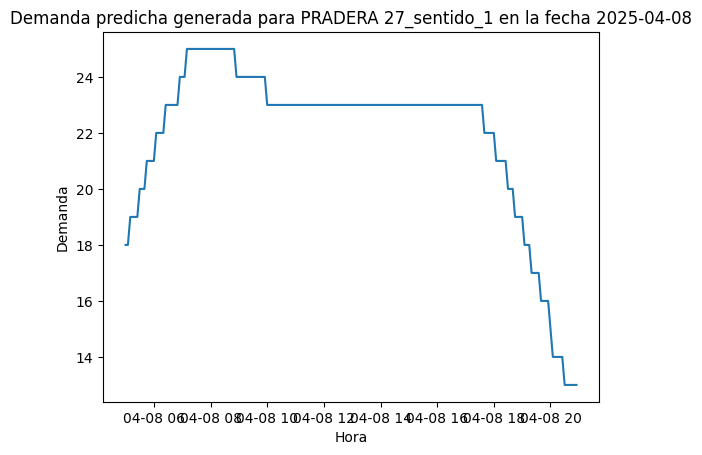

Demanda predicha generada para PRADERA 27_sentido_1 en la fecha 2025-04-08


/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dates = pd.date_range(
<ipython-input-5-597f76e25f69>:24: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future['ds'] = pd.date_range(start=f"{fecha_prediccion} 05:00:00", periods=periodos, freq=frecuencia)


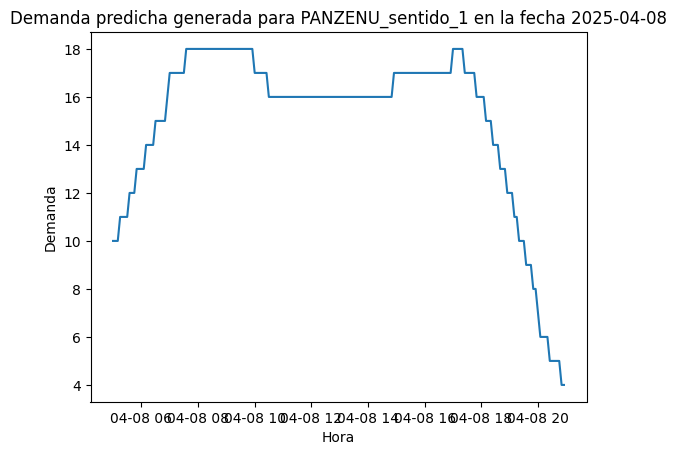

Demanda predicha generada para PANZENU_sentido_1 en la fecha 2025-04-08


/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dates = pd.date_range(
<ipython-input-5-597f76e25f69>:24: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future['ds'] = pd.date_range(start=f"{fecha_prediccion} 05:00:00", periods=periodos, freq=frecuencia)


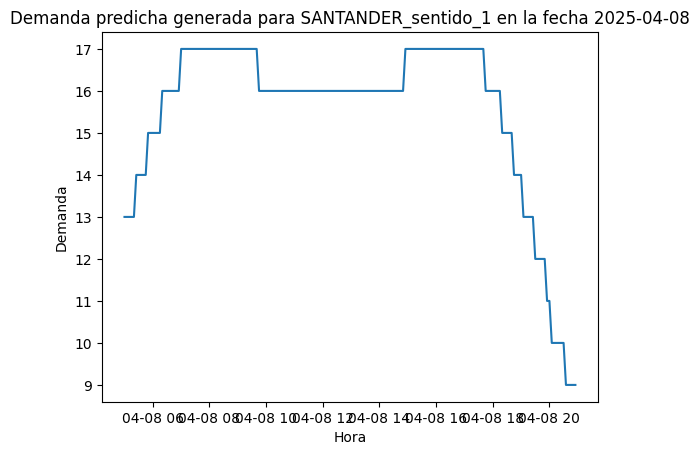

Demanda predicha generada para SANTANDER_sentido_1 en la fecha 2025-04-08


In [ ]:
# 4. Entrenar modelos para cada ruta y sentido
for ruta in rutas:
    for sentido in sentidos:
        model, train_prophet, test_prophet, metrics = entrenar_modelo_prophet(
            data=data,
            ruta=ruta,
            sentido=sentido,
            frecuencia=frecuencia,
            split_date=split_date
        )
        if model is not None:
            clave = f"{ruta}_sentido_{sentido}"
            modelos[clave] = model
            metricas[clave] = metrics
            train_data[clave] = train_prophet
            test_data[clave] = test_prophet
            print(f"Modelo entrenado para {clave} con RMSE: {metrics['RMSE']}, MAE: {metrics['MAE']}")
        else:
            print(f"No se entrenó modelo para {ruta} en sentido {sentido} debido a falta de datos.")

# 5. Generar pronósticos futuros y preparar demandas para la heurística
demanda_predicha = {}

for clave, model in modelos.items():
    # Generar pronóstico futuro
    forecast_future = generar_pronostico_futuro(
        model=model,
        fecha_prediccion=fecha_prediccion,
        frecuencia=frecuencia
    )

    # Obtener demanda predicha
    demanda = obtener_demanda_predicha(forecast_future)

    # Almacenar en el diccionario
    demanda_predicha[clave] = demanda

    print(f"Demanda predicha generada para {clave} en la fecha {fecha_prediccion}")
    demanda_predicha


In [ ]:
# guardar demanda predicha en CSV
demanda_predicha_df = pd.DataFrame(demanda_predicha)
demanda_predicha_df.to_csv('demanda_predicha.csv', index=False)

In [ ]:
demanda_predicha

{'PRADERA 27_sentido_1': array([36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 46, 47, 48, 49, 49, 49, 50,
        50, 50, 49, 49, 49, 49, 49, 48, 48, 48, 48, 47, 47, 46, 46, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46,
        46, 46, 46, 46, 47, 46, 46, 45, 44, 44, 43, 42, 41, 40, 39, 38, 37,
        35, 34, 33, 32, 31, 29, 28, 27, 26, 26, 25]),
 'PANZENU_sentido_1': array([21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 35, 36, 36,
        36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 36, 36, 36, 34, 34, 34, 34,
        34, 34, 34, 33, 33, 33, 33, 33, 33, 33, 33, 33, 32, 32, 32, 32, 32,
        32, 32, 33, 33, 33, 33, 33, 34, 34, 34, 34, 35, 35, 35, 35, 36, 36,
        36, 36, 36, 35, 37, 36, 36, 35, 34, 33, 32, 31, 30, 29, 27, 26, 24,
        23, 21, 20, 19, 17, 14, 13, 12, 11, 10,  9]),
 'SANTANDER_sentido_1': array([23, 23, 24, 25, 26, 26, 27, 28, 28, 29, 29, 29, 31, 31, 